## Data Exploration
Now that we have the data, let's load it up and take a look.

In [1]:
# Add parent directory to path to allow import of config.py
import sys
sys.path.append('..')
import config as conf

import pandas as pd
print(f'Pandas {pd.__version__}')

Pandas 1.4.3


The competition recommends including external data sources and provides some 'starter' US census data in 'census_starter.csv'. But. I think we should start with just the training data and use it to set a baseline score that we can then try and improve upon by adding more data.

In [2]:
training_df = pd.read_csv(f'{conf.DATA_PATH}/train.csv.zip', compression='zip')
training_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122265 entries, 0 to 122264
Data columns (total 7 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   row_id                 122265 non-null  object 
 1   cfips                  122265 non-null  int64  
 2   county                 122265 non-null  object 
 3   state                  122265 non-null  object 
 4   first_day_of_month     122265 non-null  object 
 5   microbusiness_density  122265 non-null  float64
 6   active                 122265 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 6.5+ MB


In [3]:
training_df.head()

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243


In [4]:
# Set dtype on first day of month column
training_df['first_day_of_month'] =  pd.to_datetime(training_df['first_day_of_month'])

Here are the column descriptions from the Kaggle competition site:
+ **row_id** - An ID code for the row.
+ **cfips** - A unique identifier for each county using the Federal Information Processing System. The first two digits correspond to the state FIPS code, while the following 3 represent the county.
+ **county_name** - The written name of the county.
+ **state_name** - The name of the state.
+ **first_day_of_month** - The date of the first day of the month.
+ **microbusiness_density** - Microbusinesses per 100 people over the age of 18 in the given county. This is the target variable. The population figures used to calculate the density are on a two-year lag due to the pace of update provided by the U.S. Census Bureau, which provides the underlying population data annually. 2021 density figures are calculated using 2019 population figures, etc.
+ **active** - The raw count of microbusinesses in the county. Not provided for the test set.

As stated above, we are going to use *microbusiness_density* only to start and then build from there. The plan being to predict the future microbusiness density from the past microbusiness density for each location.

Let's take a closer look at the microbusiness density data.

In [5]:
training_df['microbusiness_density'].describe()

count    122265.000000
mean          3.817671
std           4.991087
min           0.000000
25%           1.639344
50%           2.586543
75%           4.519231
max         284.340030
Name: microbusiness_density, dtype: float64

Looks like we have at least one zero and possibly one extreme high outlier. Let's check this out.

In [6]:
zero_count = (training_df['microbusiness_density'] == 0).sum()
zero_percent = (zero_count / len(training_df['microbusiness_density'])) * 100
print(f'Zero count: {zero_count} ({zero_percent:.2f}%)')

Zero count: 26 (0.02%)


In [7]:
zero_microbusiness_density = training_df[training_df['microbusiness_density'] == 0]
zero_microbusiness_density

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active
55632,28055_2021-02-01,28055,Issaquena County,Mississippi,2021-02-01,0.0,0
55633,28055_2021-03-01,28055,Issaquena County,Mississippi,2021-03-01,0.0,0
55634,28055_2021-04-01,28055,Issaquena County,Mississippi,2021-04-01,0.0,0
55635,28055_2021-05-01,28055,Issaquena County,Mississippi,2021-05-01,0.0,0
55636,28055_2021-06-01,28055,Issaquena County,Mississippi,2021-06-01,0.0,0
55637,28055_2021-07-01,28055,Issaquena County,Mississippi,2021-07-01,0.0,0
55638,28055_2021-08-01,28055,Issaquena County,Mississippi,2021-08-01,0.0,0
55639,28055_2021-09-01,28055,Issaquena County,Mississippi,2021-09-01,0.0,0
55640,28055_2021-10-01,28055,Issaquena County,Mississippi,2021-10-01,0.0,0
55641,28055_2021-11-01,28055,Issaquena County,Mississippi,2021-11-01,0.0,0


Looks like two counties had no microbusinesses for part of the dataset's date range. Presumably, some microbusinesses opened - hence the inclusion of these counties in the dataset. Let's take a look at Issaquena County to verify this explanation.

In [8]:
issaquena_county = training_df[training_df['county'] == 'Issaquena County']
issaquena_county.sort_values(by='first_day_of_month', ascending=True)

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active
55614,28055_2019-08-01,28055,Issaquena County,Mississippi,2019-08-01,0.179372,2
55615,28055_2019-09-01,28055,Issaquena County,Mississippi,2019-09-01,0.179372,2
55616,28055_2019-10-01,28055,Issaquena County,Mississippi,2019-10-01,0.179372,2
55617,28055_2019-11-01,28055,Issaquena County,Mississippi,2019-11-01,0.179372,2
55618,28055_2019-12-01,28055,Issaquena County,Mississippi,2019-12-01,0.179372,2
55619,28055_2020-01-01,28055,Issaquena County,Mississippi,2020-01-01,0.177305,2
55620,28055_2020-02-01,28055,Issaquena County,Mississippi,2020-02-01,0.177305,2
55621,28055_2020-03-01,28055,Issaquena County,Mississippi,2020-03-01,0.177305,2
55622,28055_2020-04-01,28055,Issaquena County,Mississippi,2020-04-01,0.177305,2
55623,28055_2020-05-01,28055,Issaquena County,Mississippi,2020-05-01,0.177305,2


Ouch, sorry Issaquena County - we were right about their being non-zero values for part of the date range. But, instead of new microbusinesses opening looks like we started with 2 which both went out of business.

Either way, let's leave the zero values in for now.

Next, how about the extreme high value(s)?

In [11]:
training_df.nlargest(50, columns=['microbusiness_density'])

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active
94382,46127_2019-10-01,46127,Union County,South Dakota,2019-10-01,284.340030,32011
94380,46127_2019-08-01,46127,Union County,South Dakota,2019-08-01,277.535980,31245
122030,56033_2022-10-01,56033,Sheridan County,Wyoming,2022-10-01,227.756650,54509
68673,32510_2022-05-01,32510,Carson City,Nevada,2022-05-01,224.538250,98716
68670,32510_2022-02-01,32510,Carson City,Nevada,2022-02-01,217.587110,95660
68671,32510_2022-03-01,32510,Carson City,Nevada,2022-03-01,217.255020,95514
68672,32510_2022-04-01,32510,Carson City,Nevada,2022-04-01,217.141300,95464
68668,32510_2021-12-01,32510,Carson City,Nevada,2021-12-01,210.047300,91484
68669,32510_2022-01-01,32510,Carson City,Nevada,2022-01-01,208.227190,91545
68667,32510_2021-11-01,32510,Carson City,Nevada,2021-11-01,206.807650,90073


Ok, so these high values don't look like artifacts - seems like there are legitimately just some counties with lots of microbusinesses. I am willing to bet there is more to this part of the story - i.e. some legal or commercial reason why these are so many in these places. Going to leave them alone for now, but we may have to treat them differently in the end if the factors driving the high density are different from other places.

This is probably going to make our life difficult - it's a pretty long skinny tail on the distribution. Some of the high numbers are on the order of 20 - 40 sigma events...

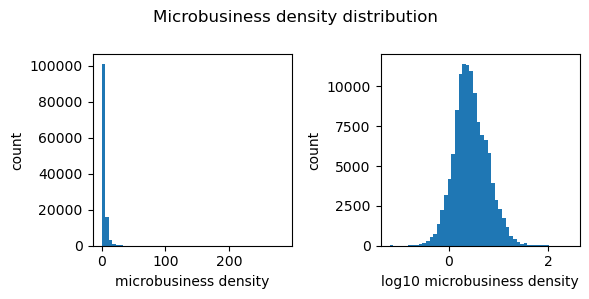

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Get just microbusiness density
microbusiness_density = training_df['microbusiness_density']

# Remove zeros so we can plot the log
microbusiness_density = microbusiness_density[microbusiness_density > 0]

fig, ax = plt.subplots(1, 2, figsize=(6,3))

ax[0].hist(microbusiness_density, bins=50)
ax[0].set_xlabel('microbusiness density')
ax[0].set_ylabel('count')

ax[1].hist(np.log10(microbusiness_density), bins=50)
ax[1].set_xlabel('log10 microbusiness density')
ax[1].set_ylabel('count')

plt.suptitle('Microbusiness density distribution')
plt.tight_layout()
plt.show()